# Example 5 - `stripy` smoothing operations

SSRFPACK is a Fortran 77 software package that constructs a smooth interpolatory or approximating surface to data values associated with arbitrarily distributed points on the surface of a sphere. It employs automatically selected tension factors to preserve shape properties of the data and avoid overshoot and undershoot associated with steep gradients.

Here we demonstrate how to access SSRFPACK smoothing through the `stripy` interface

## Notebook contents

   - [Computational mesh](#Define-a-computational-mesh)
   - [Function with noise](#Analytic-function-with-noise-and-short-wavelengths)
   - [Smoothing operator](#Smoothing-operations)
   - [Results of smoothing](#Results-of-smoothing-with-different-value-of-sm)
   

The next example is [Ex6-Scattered-Data](./Ex6-Scattered-Data.md)

## Define a computational mesh

Use the (usual) icosahedron with face points included.

In [1]:
import stripy as stripy

mesh = stripy.spherical_meshes.icosahedral_mesh(refinement_levels=4, include_face_points=True)

print(mesh.npoints)

7682


## Analytic function with noise and short wavelengths

Define a relatively smooth function that we can interpolate from the coarse mesh to the fine mesh and analyse

In [2]:
import numpy as np

def analytic(lons, lats, k1, k2):
     return  np.cos(k1*lons) * np.sin(k2*lats) 
    
def analytic_noisy(lons, lats, k1, k2, noise, short):
     return  np.cos(k1*lons) * np.sin(k2*lats) + short * (np.cos(k1*5.0*lons) * np.sin(k2*5.0*lats)) +  noise * np.random.random(lons.shape)

# def analytic_ddlon(lons, lats, k1, k2):
#      return -k1 * np.sin(k1*lons) * np.sin(k2*lats) / np.cos(lats)

# def analytic_ddlat(lons, lats, k1, k2):
#      return k2 * np.cos(k1*lons) * np.cos(k2*lats) 


analytic_sol   = analytic(mesh.lons, mesh.lats, 5.0, 2.0)
analytic_sol_n = analytic_noisy(mesh.lons, mesh.lats, 5.0, 2.0, 0.1, 0.0)

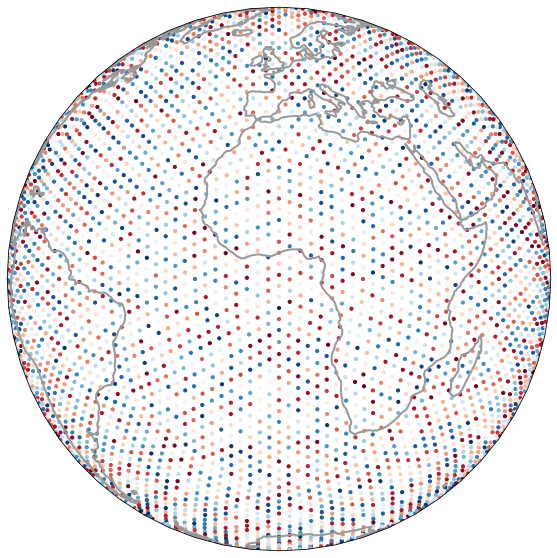

In [3]:
%matplotlib inline

import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10), facecolor="none")
ax  = plt.subplot(111, projection=ccrs.Orthographic(central_longitude=0.0, central_latitude=0.0, globe=None))
ax.coastlines(color="#999999", linewidth=2.0)
ax.set_global()

lons0 = np.degrees(mesh.lons)
lats0 = np.degrees(mesh.lats)

ax.scatter(lons0, lats0, 
            marker="o", s=10.0, transform=ccrs.PlateCarree(), c=analytic_sol_n-analytic_sol, cmap=plt.cm.RdBu)

pass

## Smoothing operations 

The `sTriangulation.smoothing` method directly wraps the SSRFPack smoother that smooths a surface f described 
by values on the mesh vertices to find a new surface f' (also described on the mesh vertices) by choosing nodal function values and gradients to minimize the linearized curvature of F subject to a bound on the deviation from the data values. 

```python

help(mesh.smoothing)
```
    smoothing(self, f, w, sm, smtol, gstol)
    
    method of stripy.spherical_meshes.icosahedral_mesh instance
    Smooths a surface f by choosing nodal function values and gradients to
    minimize the linearized curvature of F subject to a bound on the
    deviation from the data values. This is more appropriate than interpolation
    when significant errors are present in the data.
    
    Parameters
    ----------
     f : array of floats, shape (n,)
        field to apply smoothing on
     w : array of floats, shape (n,)
        weights associated with data value in f
        w[i] = 1/sigma_f^2 is a good rule of thumb.
     sm : float
        positive parameter specifying an upper bound on Q2(f).
        generally n-sqrt(2n) <= sm <= n+sqrt(2n)
     smtol : float
        specifies relative error in satisfying the constraint
        sm(1-smtol) <= Q2 <= sm(1+smtol) between 0 and 1.
     gstol : float
        tolerance for convergence.
        gstol = 0.05*mean(sigma_f)^2 is a good rule of thumb.
    
    Returns
    -------
     f_smooth : array of floats, shape (n,)
        smoothed version of f
     (dfdx, dfdy, dfdz) : tuple of floats, tuple of 3 shape (n,) arrays
        first derivatives of f_smooth in the x, y, and z directions
     err : error indicator

In [4]:
stripy_smoothed,  dds, err = mesh.smoothing(analytic_sol_n, np.ones_like(analytic_sol_n), 10.0, 0.1, 0.01)
stripy_smoothed2, dds, err = mesh.smoothing(analytic_sol_n, np.ones_like(analytic_sol_n), 1.0, 0.1, 0.01)
stripy_smoothed3, dds, err = mesh.smoothing(analytic_sol_n, np.ones_like(analytic_sol_n), 50.0, 0.1, 0.01)

delta_n  = analytic_sol_n - stripy_smoothed
delta_ns = analytic_sol   - stripy_smoothed

delta_n2  = analytic_sol_n - stripy_smoothed2
delta_ns2 = analytic_sol   - stripy_smoothed2

delta_n3  = analytic_sol_n - stripy_smoothed3
delta_ns3 = analytic_sol   - stripy_smoothed3

In [5]:
## This can be an issue on jupyterhub

from xvfbwrapper import Xvfb
vdisplay = Xvfb()
try:
    vdisplay.start()
    xvfb = True

except:
    xvfb = False

OSError: Can not find Xvfb. Please install it and try again.

## Results of smoothing with different value of `sm`

LavaVu Run error: Error creating OpenGL context




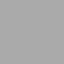

In [6]:
import lavavu

lv = lavavu.Viewer(border=False, background="#FFFFFF", resolution=[666,666], near=-10.0)

nodes = lv.points("nodes", pointsize=3.0, pointtype="shiny", colour="#448080", opacity=0.75)
nodes.vertices(mesh.points)

tris = lv.triangles("triangles",  wireframe=False, colour="#77ff88", opacity=1.0)
tris.vertices(mesh.points)
tris.indices(mesh.simplices)
tris.values(analytic_sol_n, label="original")
tris.values(stripy_smoothed, label="smoothed")
tris.values(stripy_smoothed2, label="smoothed2")
tris.values(stripy_smoothed3, label="smoothed3")


tris.values(delta_n, label="delta_n")
tris.values(delta_ns, label="delta_ns")

tris.values(delta_n2, label="delta_n2")
tris.values(delta_ns2, label="delta_ns2")

tris.values(delta_n3, label="delta_n3")
tris.values(delta_ns3, label="delta_ns3")



# and the errors

tris.colourmap("#990000 #FFFFFF #000099")


cb = tris.colourbar()

# view the pole

lv.translation(0.0, 0.0, -3.0)
lv.rotation(-20, 0.0, 0.0)



lv.control.Panel()
lv.control.Range('specular', range=(0,1), step=0.1, value=0.4)
lv.control.Checkbox(property='axis')
lv.control.ObjectList()
tris.control.List(options=["original", "smoothed", "smoothed2", "smoothed3",
                   "delta_n", "delta_ns", 
                   "delta_n2", "delta_ns2", 
                   "delta_n3", "delta_ns3"], property="colourby", value="original", command="redraw")
lv.control.show()

The next example is [Ex6-Scattered-Data](./Ex6-Scattered-Data.md)

In [7]:
vdisplay.stop()

NameError: name 'vdisplay' is not defined